In [17]:
import pymc3 as pm
import numpy as np
from scipy import optimize
import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
np.random.seed(123)

alpha, sigma = 1, 1
beta = [1, 2.5]

size = 100

X1 = np.random.randn(size)
X2 = np.random.randn(size) * 0.2

Y = alpha + beta[0] * X1 + beta[1] * X2 + np.random.randn(size) * sigma

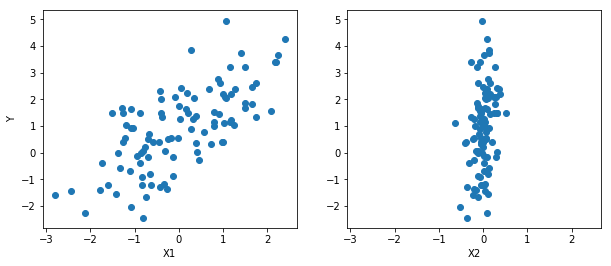

In [12]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10, 4))
axes[0].scatter(X1, Y)
axes[1].scatter(X2, Y)
axes[0].set_ylabel('Y')
axes[0].set_xlabel('X1')
axes[1].set_xlabel('X2')

In [14]:
basic_model = pm.Model()
with basic_model:
    # priors for unknown model parameters
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=10, shape=2)
    sigma = pm.HalfNormal('sigma', sd=1)
    
    # expected value of the outcome
    mu = alpha + beta[0] * X1 + beta[1] * X2
    
    # likelihood (sampling distribution) of observations
    Y_obs = pm.Normal('Y_obs', mu=mu, sd=sigma, observed=Y)

The maximum a posteriori (MAP) estimate for a model, is the mode of the posterior distribution and is generally found using numerical optimization methods. This is often fast and easy to do, but only gives a point estimate for the parameters and can be biased if the mode isn’t representative of the distribution. PyMC3 provides this functionality with the find_MAP function.

In [16]:
map_estimate = pm.find_MAP(model=basic_model)
map_estimate

Optimization terminated successfully.
         Current function value: 149.017982
         Iterations: 16
         Function evaluations: 21
         Gradient evaluations: 21


{'alpha': array(0.9065985497559482),
 'beta': array([ 0.94848602,  2.60705514]),
 'sigma_log__': array(-0.032781470174030373)}

By default, find_MAP uses the Broyden–Fletcher–Goldfarb–Shanno (BFGS) optimization algorithm to find the maximum of the log-posterior but also allows selection of other optimization algorithms from the scipy.optimize module. For example, below we use Powell’s method to find the MAP.

In [18]:
map_estimate = pm.find_MAP(model=basic_model, fmin=optimize.fmin_powell)
map_estimate

Optimization terminated successfully.
         Current function value: 149.019762
         Iterations: 4
         Function evaluations: 176


{'alpha': array(0.9090521898975632),
 'beta': array([ 0.95140146,  2.61437458]),
 'sigma_log__': array(-0.03000977520281219)}

In [19]:
with basic_model:
    # draw 500 posterior samples
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 350.23:   1%|          | 2137/200000 [00:26<41:46, 78.95it/s]
Interrupted at 2,137 [1%]: Average Loss = 512.47
  1%|          | 9/1000 [00:02<05:59,  2.76it/s]/Users/jaco/.pyenv/versions/3.6.1/envs/tabby/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:418: UserWarning: Chain 0 contains only 0 samples.
  % (self._chain_id, n))
/Users/jaco/.pyenv/versions/3.6.1/envs/tabby/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:420: UserWarning: Step size tuning was enabled throughout the whole trace. You might want to specify the number of tuning steps.
  warnings.warn('Step size tuning was enabled throughout the whole '
/Users/jaco/.pyenv/versions/3.6.1/envs/tabby/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)



In [20]:
with basic_model:

    # obtain starting values via MAP
    start = pm.find_MAP(fmin=optimize.fmin_powell)

    # instantiate sampler
    step = pm.Slice()

    # draw 5000 posterior samples
    trace = pm.sample(5000, step=step, start=start)

  0%|          | 2/5500 [00:00<08:03, 11.36it/s]

Optimization terminated successfully.
         Current function value: 149.019762
         Iterations: 4
         Function evaluations: 176


100%|██████████| 5500/5500 [07:32<00:00, 12.14it/s]


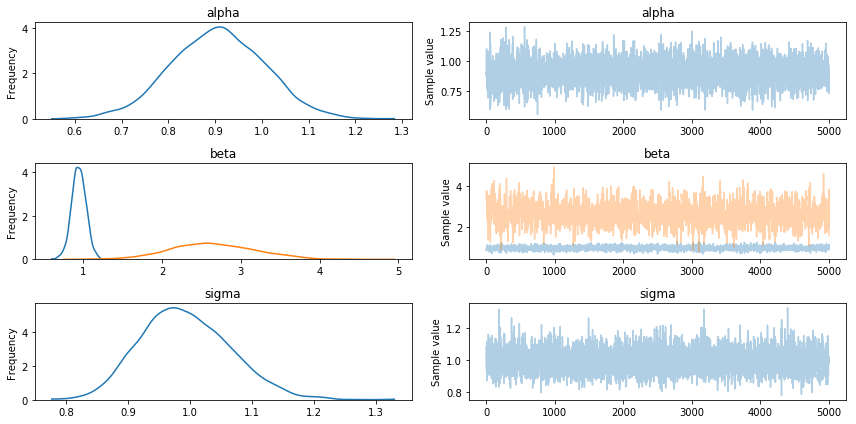

In [21]:
_ = pm.traceplot(trace)

In [22]:
pm.summary(trace)


alpha:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.906            0.099            0.001            [0.716, 1.103]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.708          0.838          0.907          0.974          1.099


beta:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.944            0.092            0.002            [0.764, 1.126]
  2.650            0.539            0.019            [1.695, 3.775]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.760          0.884          0.944          1.005          1.125
  1.613          2.279          2.625   